In [1]:
%matplotlib inline


# Multi-instrument joint analysis


## Introduction


We are goind to reproduce the analysis of the public Crab datasets from [Nigro et al. 2019](https://www.aanda.org/articles/aa/full_html/2019/05/aa34938-18/aa34938-18.html). \
In practice, we have to:

- Read a DL4 datasets file
- Define the `~gammapy.modeling.models.Models` to apply to the datasets from a list of `~gammapy.modeling.models.SkyModel`.
- Create a `~gammapy.modeling.Fit` object and run it to fit the model parameters
- Plot the spectrum obtained from the joint fit together with the ones obtained for each instrument fit in their respective validity range.



In [2]:
from IPython.display import display

from pathlib import Path

import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord

import matplotlib.pyplot as plt

from gammapy.datasets import Datasets

from gammapy.modeling import Fit
from gammapy.modeling.models import Models



## Read the models

Read the models we defined previously

In [3]:
path = Path("models")
path.mkdir(exist_ok=True)

filename = path / "models_crab.yaml"
models = Models.read(filename)

## Read the datasets

We read all the public datasets from the Crab and attach them the models

In [4]:
filename = "./datasets/joint_crab/datasets_joint_crab_1d.yaml"

datasets_joint = Datasets.read(filename)

datasets_joint.models = models

/Users/qremy/Work/GitHub/gammapy/gammapy/utils/scripts.py:65: UserWarning: Checksum verification failed for datasets/joint_crab/datasets_joint_crab_1d.yaml.
  warnings.warn(f"Checksum verification failed for {filename}.", UserWarning)


In [5]:
datasets_joint.names

['_fermi_obs0',
 '_fact_stacked',
 '_magic_obs5029747',
 '_magic_obs5029748',
 '_veritas_obs54809',
 '_veritas_obs57993',
 '_hess_obs23523',
 '_hess_obs23526',
 '_hess_obs23559',
 '_hess_obs23592',
 '_hawc_nHit-1',
 '_hawc_nHit-2',
 '_hawc_nHit-3',
 '_hawc_nHit-4',
 '_hawc_nHit-5',
 '_hawc_nHit-6',
 '_hawc_nHit-7',
 '_hawc_nHit-8',
 '_hawc_nHit-9']

# Joint fit

Define the fit instance

In [6]:
optimize_opts = dict(strategy=1, tolerance=0.1)
fit = Fit(optimize_opts=optimize_opts)

Let's start to fit the data from each instrument indepently

Think about how to determine the energy range for each dataset!

Save the results for each instrument into a dictionary

In [7]:
instruments = ["fermi", "magic", "veritas", "fact", "hess", "hawc"]
results = []
for instrument in instruments:
    datasets_instrument = Datasets([d for d in datasets_joint if instrument in d.name])
    datasets_instrument.models = models
    result_instrument = fit.run(datasets=datasets_instrument)
    
    #here we try to define the validity range of the fit 
    #we defined it as where the safe mask is true AND where there is detected counts.
    Emin = np.inf*u.TeV
    Emax = -np.inf*u.TeV
    for d in datasets_instrument:
        energy_edges = d.counts.geom.axes["energy"].edges
        ind = np.where(d.mask_safe&d.counts>0)[0]
        Emin = np.minimum(Emin, energy_edges[ind[0]])
        Emax = np.maximum(Emax, energy_edges[ind[-1]+1])

    #save the datasets, fit results and valid energy range
    result = dict()
    result["instrument"]=instrument
    result["Emin"] = Emin
    result["Emax"] = Emax
    result["models_best_fit"] = datasets_instrument.models.copy()
    result["result_minuit"] = result_instrument
    result["datasets"] = datasets_instrument
    results.append(result)


HDU 'MASK_FIT' not found
HDU 'MASK_FIT' not found
HDU 'MASK_FIT' not found
HDU 'MASK_FIT' not found
HDU 'MASK_FIT' not found
HDU 'MASK_FIT' not found
HDU 'MASK_FIT' not found
HDU 'MASK_FIT' not found
HDU 'MASK_FIT' not found


Now we do the joint fit

In [8]:
result_joint = fit.run(datasets=datasets_joint)


In [9]:
Emin = u.Quantity([res["Emin"] for res in results]).min()
Emax = u.Quantity([res["Emax"] for res in results]).max()

result = dict()
result["instrument"]="joint"
result["Emin"] = Emin
result["Emax"] = Emax
result["models_best_fit"] = datasets_joint.models.copy()
result["result_minuit"] = result_joint
result["datasets"] = datasets_joint
results.append(result)


In [10]:
results

[{'instrument': 'fermi',
  'Emin': <Quantity 0.03162278 TeV>,
  'Emax': <Quantity 1.58489319 TeV>,
  'models_best_fit': <gammapy.modeling.models.core.DatasetModels at 0x154763f50>,
  'result_minuit': <gammapy.modeling.fit.FitResult at 0x14de99890>,
  'datasets': <gammapy.datasets.core.Datasets at 0x1547bd650>},
 {'instrument': 'magic',
  'Emin': <Quantity 0.07943282 TeV>,
  'Emax': <Quantity 14.12537545 TeV>,
  'models_best_fit': <gammapy.modeling.models.core.DatasetModels at 0x154729050>,
  'result_minuit': <gammapy.modeling.fit.FitResult at 0x154895710>,
  'datasets': <gammapy.datasets.core.Datasets at 0x154829d90>},
 {'instrument': 'veritas',
  'Emin': <Quantity 0.15848932 TeV>,
  'Emax': <Quantity 31.6227766 TeV>,
  'models_best_fit': <gammapy.modeling.models.core.DatasetModels at 0x1547f8050>,
  'result_minuit': <gammapy.modeling.fit.FitResult at 0x1546eddd0>,
  'datasets': <gammapy.datasets.core.Datasets at 0x14de83610>},
 {'instrument': 'fact',
  'Emin': <Quantity 0.56234133 TeV

and compare the results by plotting them all together

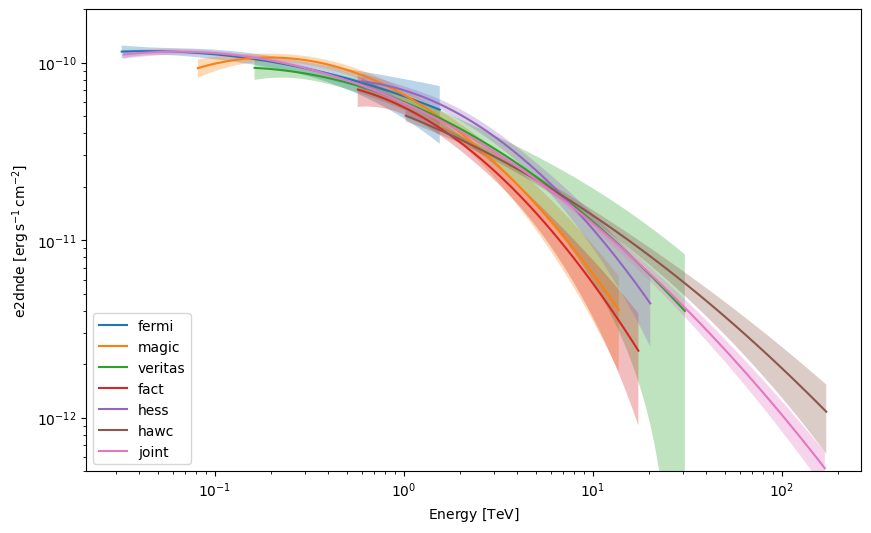

In [11]:
fig, ax = plt.subplots(figsize=(10,6))

plot_kwargs = {
    "sed_type": "e2dnde",
    "ax": ax,
}
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

for result, color in zip(results, colors):
    model = result["models_best_fit"]["crab"]
    energy_bounds=u.Quantity([result["Emin"], result["Emax"]]).to("TeV")
    model.spectral_model.plot(energy_bounds,
        **plot_kwargs, label=result["instrument"], ls="-", color=color
    )
    model.spectral_model.plot_error(energy_bounds,
                                    facecolor=color, alpha=0.3, **plot_kwargs)
ax.set_ylim(5e-13, 2e-10)
ax.legend(loc=3)
plt.show()


## Likelihood contours

In order to compute likelihhod contours of the fitted parameters 
we copy some code from the documentation https://docs.gammapy.org/1.2/tutorials/api/fitting.html#computing-contours-using-stat-contour

In [12]:
from itertools import combinations
from gammapy.visualization.utils import plot_contour_line


def make_contours(fit, datasets, result, npoints, sigmas):
    cts_sigma = []
    for sigma in sigmas:
        contours = dict()
        for par_1, par_2 in combinations(["alpha", "beta", "amplitude"], r=2):
            idx1, idx2 = datasets.parameters.index(par_1), datasets.parameters.index(
                par_2
            )
            name1 = datasets.models.parameters_unique_names[idx1]
            name2 = datasets.models.parameters_unique_names[idx2]
            contour = fit.stat_contour(
                datasets=datasets,
                x=datasets.parameters[par_1],
                y=datasets.parameters[par_2],
                numpoints=npoints,
                sigma=sigma,
            )
            contours[f"contour_{par_1}_{par_2}"] = {
                par_1: contour[name1].tolist(),
                par_2: contour[name2].tolist(),
            }
        cts_sigma.append(contours)
    return cts_sigma

def make_plots(cts_sigma, axes, label, color):
    pars = {
        "phi": r"$\phi_0 \,/\,(10^{-11}\,{\rm TeV}^{-1} \, {\rm cm}^{-2} {\rm s}^{-1})$",
        "alpha": r"$\alpha$",
        "beta": r"$\beta$",
    }

    panels = [
        {
            "x": "alpha",
            "y": "phi",
            "cx": (lambda ct: ct["contour_alpha_amplitude"]["alpha"]),
            "cy": (lambda ct: np.array(1e11) * ct["contour_alpha_amplitude"]["amplitude"]),
        },
        {
            "x": "beta",
            "y": "phi",
            "cx": (lambda ct: ct["contour_beta_amplitude"]["beta"]),
            "cy": (lambda ct: np.array(1e11) * ct["contour_beta_amplitude"]["amplitude"]),
        },
        {
            "x": "alpha",
            "y": "beta",
            "cx": (lambda ct: ct["contour_alpha_beta"]["alpha"]),
            "cy": (lambda ct: ct["contour_alpha_beta"]["beta"]),
        },
    ]

    for p, ax in zip(panels, axes):
        xlabel = pars[p["x"]]
        ylabel = pars[p["y"]]
        for ks in range(len(cts_sigma)):
            plot_contour_line(
                ax,
                p["cx"](cts_sigma[ks]),
                p["cy"](cts_sigma[ks]),
                lw=2.5,
                color=color,
                label=label,
            )
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)

and we apply use it with our datasets and the previous fit results

/Users/qremy/anaconda3/envs/gpy-dev/lib/python3.11/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/qremy/anaconda3/envs/gpy-dev/lib/python3.11/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/qremy/Work/GitHub/gammapy/gammapy/stats/fit_statistics.py:209: RuntimeWarning: overflow encountered in square
  D = np.sqrt(C**2 + 4 * alpha * (alpha + 1) * n_off * mu_sig)
/Users/qremy/anaconda3/envs/gpy-dev/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


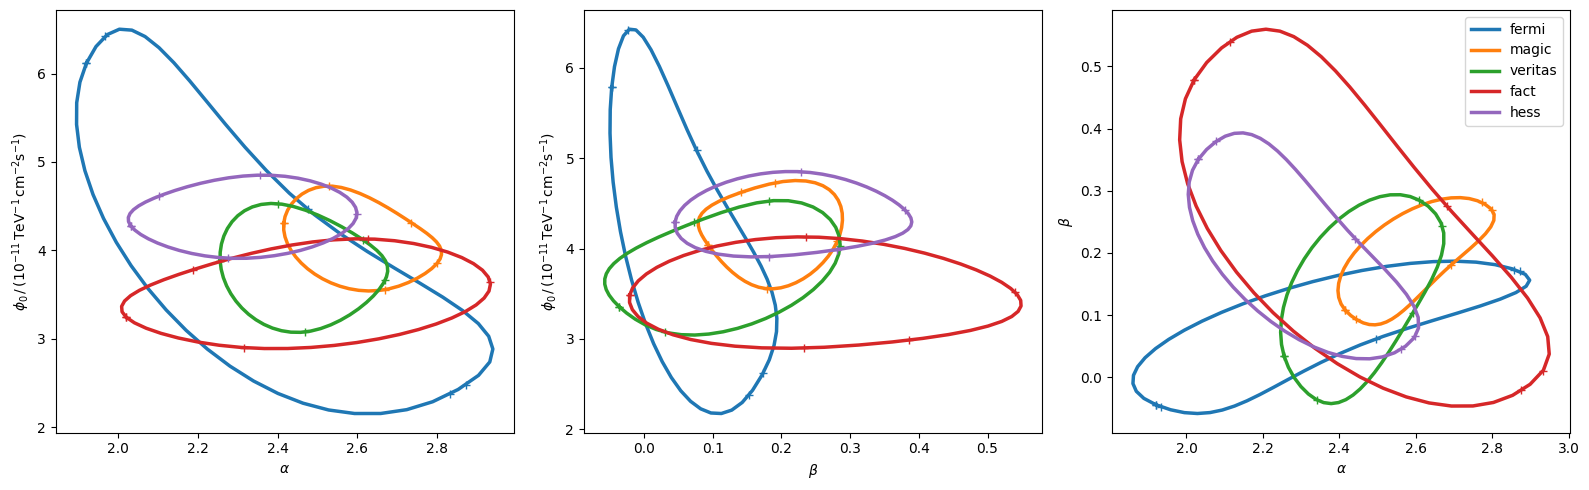

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for result, color in zip(results, colors):
    if result["instrument"] in ["hawc", "joint"]:
        #we skip hawc because it is slower to compute on a MapDataset
        continue
    with np.errstate(invalid="ignore", divide="ignore"): #just to hide numpy warnings 
        cts_sigma = make_contours(
            fit=fit,
            datasets=result["datasets"],
            result=result["result_minuit"],
            npoints=5,
            sigmas=[2],
        )
    make_plots(cts_sigma, axes, color=color, label=result["instrument"])
plt.legend()
plt.tight_layout()
